# Channel flow with heat transfer: single-phase reference and bubbly case.

## Introduction
 
 Validation made by: Guillaume BOIS (gb218285)

 Report created on 12/02/2025

### TRUST parameters
 
* Version TRUST :  1.9.6_beta


### Description

This test case is inspired from the single- and two-phase channels studied by Sonolet (2023), see chap. 2 and in particular Sec 2.3 and 2.4.
The channel dimensions are $2\pi h\times \pi h\times 2h$ with the channel half-width $h=5~\text{mm}$.

The flow is sustained by a source term, initially $S_0 = \tau_w/h = 0.010179478266401963 / 0.005 =2.0358956532803925 $ but for a better statistical convergence, 
it evolves in time according to an ad-hoc law including damping : 
\begin{equation}
\frac{\partial S(t)}{\partial t} = 59438 (0.06468292398802113-\left\langle u\right\rangle)+20. (2.0358956532803925-S(t)) 
\end{equation}
triple periodic box with 57 bubbles of $D_b=1mm$ and a uniform resolution 19.2 cells/diam. This setup is the same as the coarse case of Chap. 3 of Sonolet (2023) for $Re_b\approx 400$. It allows measurements of the effect of channel turbulence.

To reduce the cost, the coarsest case from Sonolet (2023) is further reduced (by 6 in wall normal direction) from $192 \times 96 \times 576$ to $192 \times 96 \times 96$, resulting in domain of $\approx 1.78$Mons elements.

For the time being, this case is run with an Euler Explicit time-scheme instead of RK3 used by Sonolet (2023).


The Reynolds friction number is controlled around $Re_\tau = 180$ and liquid Prandtl is set to $Pr=1$.
An incoming wall flux $q_w=1W/m^2$ is prescribed at both walls. 
The keyword `wall_flux` is set to impose a sink of energy compensating incoming fluxes. 

The temperature is rendered dimensionless by 
\begin{equation}
T^+ = \frac{T \rho C_p u_\tau}{q_w}
\end{equation}

Log-log mean velocity profile (see Fig. 2.2b from Sonolet (2023))

Velocity fluctuations in the channel (see Figs. 2.3-2.4 from Sonolet (2023))

Temperature dimensionless velocity profile (see Fig. 2.6-2.7 from Sonolet (2023))

Correlations velocity/temperature (see Fig. 2.8 from Sonolet (2023))

Energy budget (see Fig. 2.9 from Sonolet (2023))


In [ ]:
rhol=594.38
lda=1
cp=1.46355028026988002e+05
mul=6.8327e-5
for cp in [1.46355028026988002e+05
    , 2.06133842291531982e+04
    , 1.46355028026988002e+04
    , 7.31775140134940011e+03
    , 1.46355028026987998e+03
    , 1.03912069899160997e+04
    , 2.92710056053975995e+03
    , 3.82789450583224971e+04] :
    Pr=(mul*cp/lda)
    print(Pr)

10.000000000000009
1.4084507042253505
1.0000000000000009
0.5000000000000004
0.10000000000000009
0.7099999999999973
0.20000000000000018
2.615485479000001


In [1]:
# prepare


In [5]:
from trustutils import run
 
run.reset() 
run.addCase(".","test.data",nbProcs=8)

# Tester un pre_run avec un seuil du solver plus lache si la reprise après le switch est trop diffile pour le solveur de pression
#dic_pre = {"procs":"1 1 1", "nb_pas": 1, "timestep":1.e-8, "repr_file":"very_coarse.sauv.lata", \
#          "seuil_gros":1.e-3 , "seuil_AMG":1.e-2 , \
#           "# projection_initiale #":"projection_initiale" }
#run.addCaseFromTemplate("template_kawa.data",".",dic_pre, nbProcs=1, targetData="pre_run.data")

dic_cas = {"procs":"3 3 1", "nb_pas": 5000, "timestep":1., "repr_file":"very_coarse.sauv.lata", \
          "seuil_gros":1e-8 , "seuil_AMG":1e-7 }
run.addCaseFromTemplate("template_kawa.data",".",dic_cas, nbProcs=9,targetData="temperature_channel_monop.data")
run.addCase(".","switch.data",nbProcs=9)
run.executeCommand("tar xzf sauv_lata.tgz",verbose=1)
#run.executeCommand("sed -i \"/rank_reprise_temperature/d\" temperature_channel_monop.data")
run.printCases()
run.runCases() # Mettre prevent_concurrent si pre_run.data et changer "repr_file":"very_coarse dans dic_cas par "pre_run"

tar xzf sauv_lata.tgz



### Test cases 
* ./test.data with 8 procs
* ./temperature_channel_monop.data with 9 procs
* ./switch.data with 9 procs


Running ...
  => A total of 3 cases were (successfully) run in 2043.6s.


# Single-phase results

### Canal : Lambda2 (structures turbulentes)
 
 

KeyboardInterrupt: 

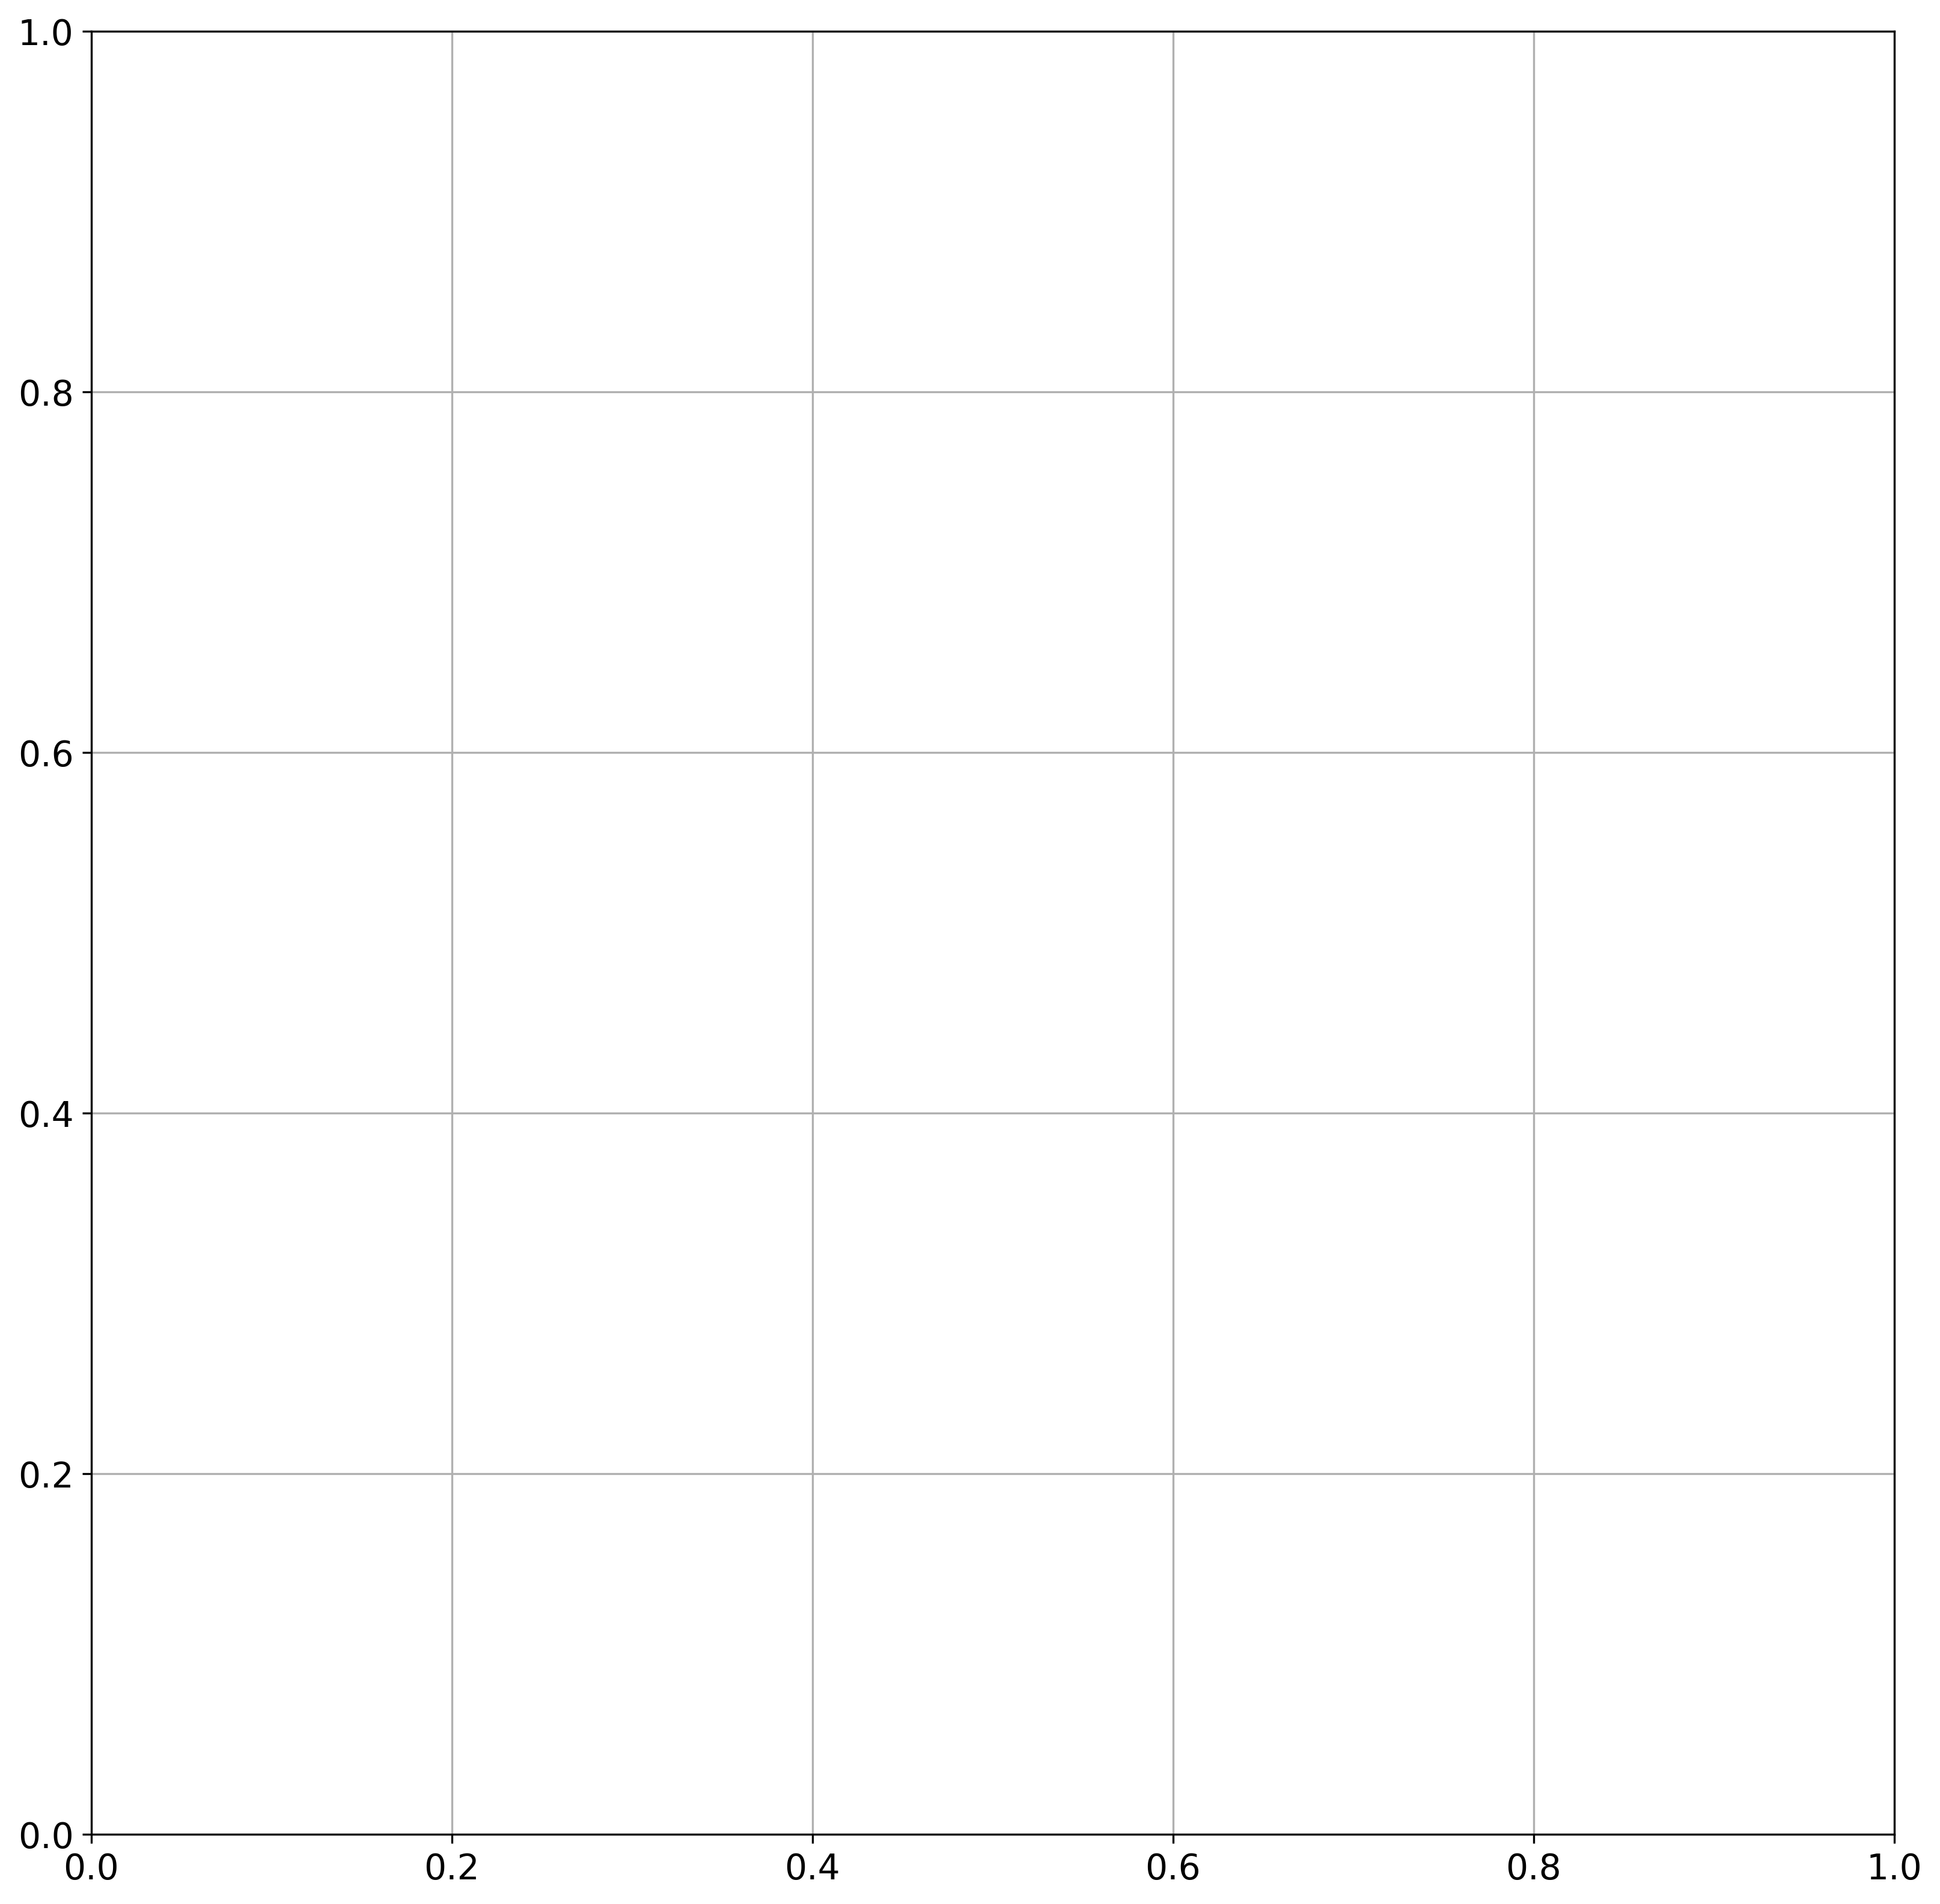

In [7]:
from trustutils import visit
 
# visu = visit.Show("temperature_channel_monop.lata","Contour","LAMBDA2_ELEM_DOM",nX=2, subtitle="Final state", iteration=-1, plotmesh=False)
visu = visit.Show("temperature_channel_monop.lata","Contour","LAMBDA2_ELEM_DOM",iteration=-1, plotmesh=False)
visu.visitCommand("ContourAtts = ContourAttributes()")
visu.visitCommand("ContourAtts.contourMethod = ContourAtts.Value")
visu.visitCommand("ContourAtts.contourNLevels = 10")
visu.visitCommand("ContourAtts.contourValue = (-200, 200)")
visu.visitCommand("SetPlotOptions(ContourAtts)")
visu.normal3D([0,1,0])
visu.up3D([0,0,-1])
visu.zoom3D([0,0,1.])
visu.plot()

## Resultats champs de vitesse et temperature
### Etat final (vz et T)

In [ ]:
from trustutils import visit

for iters in [0,-1]:
    visu = visit.Show("temperature_channel_monop.lata","Pseudocolor","VELOCITY_X_FACES_DOM_dual",mesh="DOM_dual", iteration=iters)
    visu.normal3D([0,1,0])
    visu.up3D([1,0,0])
    visu.zoom3D([0,0,1.])
    visu.plot()

    for i in range(3):
        visu = visit.Show("temperature_channel_monop.lata","Pseudocolor",f"TEMPERATURE_OF_{i}_DOM_dual",mesh="DOM", iteration=iters)
        visu.normal3D([0,1,0])
        visu.up3D([1,0,0])
        visu.zoom3D([0,0,1.])
        visu.plot()

### Essaim fixe : Etat final (vz moyenne en temps)
 
 

In [ ]:
from trustutils import visit
 
visu = visit.Show("diph_fixe.sauv.lata","Pseudocolor","INTEGRATED_VELOCITY_X_FACES_DOM_dual",mesh="DOM_dual")
visu.normal3D([0,1,0])
visu.up3D([1,0,0])
visu.zoom3D([0,0,1.])
visu.plot()

## Resultats convergence en temps
 


In [ ]:
from trustutils import plot 
 
fig = plot.Graph(r"debit en fonction du temps pour le canal") 
data = plot.loadText("DNS_canal_acceleration.out")
fig.add((data[1]),(data[3]),label=r"Undefined",marker='+')

fig.label(r"t",r"debit")


In [ ]:
from trustutils import plot 
 
fig = plot.Graph(r"debit en fonction du temps pour les essaims") 
data = plot.loadText("DNS_swarm_acceleration.out")
fig.add((data[1]),(data[3]),label=r"Undefined",marker='+')
data = plot.loadText("DNS_fixe_acceleration.out")
fig.add((data[1]),(data[3]),label=r"Undefined",marker='+')

fig.label(r"t",r"debit")


## Resultats statistiques
 


In [ ]:
from trustutils import plot 
 
fig = plot.Graph(r"taux de vide pour un ecoulement en canal") 
data = plot.loadText("diphasique_statistiques_0.030000.txt")
fig.add((data[0]),(data[1]),label=r"Undefined",marker='+')

fig.label(r"z",r"taux de vide")


In [ ]:
from trustutils import plot 
 
fig = plot.Graph(r"taux de vide pour essaims") 
data = plot.loadText("diphasique_statistiques_0.030000.txt")
fig.add((data[0]),(data[1]),label=r"Undefined",marker='+')
data = plot.loadText("diphasique_statistiques_0.009000.txt")
fig.add((data[0]),(data[1]),label=r"Undefined",marker='+')

fig.label(r"z",r"taux de vide")


In [ ]:
from trustutils import plot 
 
fig = plot.Graph(r"vitesse relative pour un ecoulement en canal") 
data = plot.loadText("diphasique_statistiques_0.030000.txt")
fig.add((data[0]),(((data[6])/(1.-(data[1])))-((data[2])/(data[1]))),label=r"Undefined",marker='+')

fig.label(r"z",r"ur")


In [ ]:
from trustutils import plot 
 
fig = plot.Graph(r"vitesse relative pour essaims") 
data = plot.loadText("diphasique_statistiques_0.030000.txt")
fig.add((data[0]),(((data[6])/(1.-(data[1])))-((data[2])/(data[1]))),label=r"Undefined",marker='+')
data = plot.loadText("diphasique_statistiques_0.009000.txt")
fig.add((data[0]),(((data[6])/(1.-(data[1])))-((data[2])/(data[1]))),label=r"Undefined",marker='+')

fig.label(r"z",r"ur")
